In [146]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from tensorflow.keras import datasets, layers, models, Sequential
from tensorflow.keras.applications import ResNet50, VGG16
import keras_tuner as kt
# import torch
# import torchvision
# import torchvision.transforms as transforms

In [98]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'og_data',
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(300, 500))

val_ds = tf.keras.utils.image_dataset_from_directory(
  'og_data',
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(300, 500))


Found 200 files belonging to 5 classes.
Using 140 files for training.
Found 200 files belonging to 5 classes.
Using 60 files for validation.


In [99]:
train_df = tf.keras.utils.image_dataset_from_directory(
  'ten_dino',
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(300, 500))

val_df = tf.keras.utils.image_dataset_from_directory(
  'ten_dino',
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(300, 500))


Found 1030 files belonging to 10 classes.
Using 721 files for training.
Found 1030 files belonging to 10 classes.
Using 309 files for validation.


In [100]:
class_names = train_ds.class_names
class_names


['ankylosaurus', 'brontosaurus', 'pterodactyl', 'trex', 'triceratops']

In [101]:
dino_names = train_df.class_names
dino_names

['Corythosaurus',
 'Dilophosaurus',
 'Spinosaurus',
 'Stegosaurus',
 'Velociraptor',
 'ankylosaurus',
 'brontosaurus',
 'pterodactyl',
 'trex',
 'triceratops']

In [102]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (300, 500, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

In [149]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [152]:
def build_model(hp):
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255, input_shape = (300, 500, 3)),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            input_shape = (300, 500, 3)
        ),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            activation = 'relu',
        ),
        layers.MaxPooling2D(),
        layers.Conv2D(
            filters = hp.Int('layer1_filter', min_value = 16, max_value = 128, step = 16),
            kernel_size = hp.Choice('layer1_kernel', values = [3, 5, 7]),
            input_shape = (300, 500, 3)
        ),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(
            hp.Int('dense_layer1', min_value = 16, max_value = 128, step = 16),
            activation = 'relu'
        ),
        layers.Dropout(0.2),
        layers.Dense(5, activation = 'softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [153]:
tuner = kt.Hyperband(build_model,
objective = 'val_accuracy',
max_epochs = 15,
factor = 3,
directory = 'dir',
project_name = '5class_tuner')

In [154]:
tuner.search(train_ds, validation_data = val_ds, epochs = 15, callbacks = [stop_early])

Trial 30 Complete [00h 05m 27s]
val_accuracy: 0.7166666388511658

Best val_accuracy So Far: 0.7833333611488342
Total elapsed time: 01h 07m 02s


In [159]:
best_model = tuner.get_best_models(num_models = 1)[0]

best_model

<Sequential name=sequential, built=True>

In [171]:
best_model.history

In [164]:
best_model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 702ms/step - accuracy: 0.8347 - loss: 1.2218


[1.249350905418396, 0.7833333611488342]

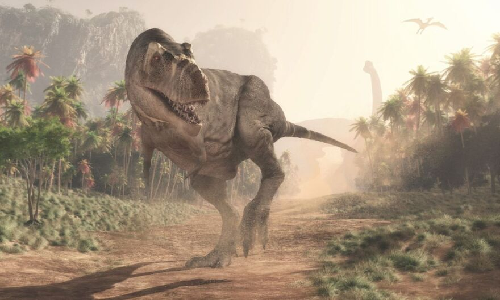

In [179]:
img

In [178]:
img = tf.keras.utils.load_img(
    'ttest.jpeg', target_size=(300, 500)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = best_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
This image most likely belongs to trex with a 21.11 percent confidence.


In [103]:
base_test = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape = (300, 500, 3)),
    VGG16(include_top = False, weights = "imagenet", input_shape = (300, 500, 3))
])

base_test.layers[-1].trainable = False
base_test.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_26 (Sequential)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [104]:
base_test.layers[-1].layers

[<InputLayer name=input_layer_24, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [105]:
base_model = VGG16(include_top = False, weights = "imagenet", input_shape = (300, 500, 3))
base_model.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 15, 512)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [106]:
# base_model.trainable = True
# for layer in base_model.layers[:-4]:
#     layer.trainable = False

# base_model.summary()

In [107]:
test = tf.keras.models.Model(base_model.input, base_model.layers[-4].output)

test.summary()

Model: "functional_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,995,072 (38.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,995,072 (38.13 MB)

In [135]:
model = Sequential()
for layer in base_test.layers[:2]:
    model.add(layer)
for layer in base_model.layers[1:11]:
    layer.trainable = False
model.add(base_model.layers[1])
model.add(base_model.layers[3])
model.add(base_model.layers[4])
model.add(base_model.layers[6])
model.add(base_model.layers[7])
model.add(base_model.layers[10])
model.add(layers.Flatten())
model.add(layers.Dense(128))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation = "softmax"))
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-5),
              metrics = ["accuracy"])

In [136]:
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_26 (Sequential)      │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 370,816 (1.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 370,816 (1.41 MB)

In [137]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [138]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 15, callbacks = stop_early)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2017 - loss: 13.5309 - val_accuracy: 0.1333 - val_loss: 22.0709
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2825 - loss: 11.4962 - val_accuracy: 0.4167 - val_loss: 10.4873
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3723 - loss: 7.2238 - val_accuracy: 0.5667 - val_loss: 6.2659
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4375 - loss: 5.2985 - val_accuracy: 0.3500 - val_loss: 3.9509
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.3332 - loss: 6.2062 - val_accuracy: 0.5167 - val_loss: 3.7046
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6069 - loss: 2.1446 - val_accuracy: 0.4667 - val_loss: 3.8574
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4028 - loss: 5.6303 - val_accuracy: 0.5167 - val_loss: 5.2923
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4289 - loss: 4.8900 - val_accuracy: 0.7000 - val_loss: 1.1697
Epoch 9/15
5

In [139]:
# inputs = tf.keras.Input(shape = (300, 500, 3))
# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255, input_shape=(300, 500, 3))(x),
# x = base_model(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128)(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(5, activation = "softmax")(x)
# model = tf.keras.Model(inputs, outputs)
# model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-5),
#               metrics = ["accuracy"])

In [140]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [141]:
# history = model.fit(train_ds, validation_data = val_ds, epochs = 15, callbacks = stop_early)

ValueError: x and y must have same first dimension, but have shapes (15,) and (11,)

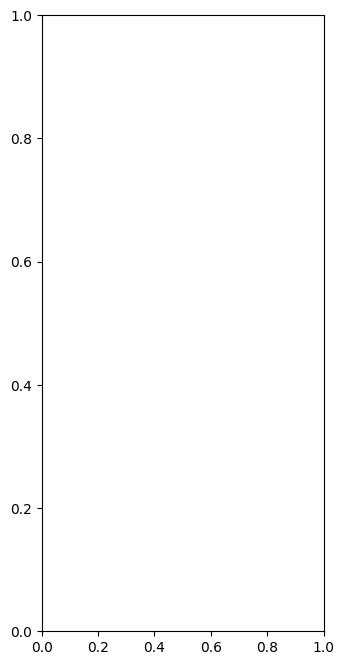

In [142]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.show()

In [143]:
model.evaluate(val_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 835ms/step - accuracy: 0.6306 - loss: 1.9945


[1.9284143447875977, 0.6333333253860474]

In [144]:

img = tf.keras.utils.load_img(
    'anktest.jpeg', target_size=(300, 500)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
This image most likely belongs to triceratops with a 36.68 percent confidence.


In [133]:
base_model10 = VGG16(include_top = False, weights = "imagenet", input_shape = (300, 500, 3))
base_model10.trainable = False

base_model10.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 15, 512)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [134]:
base_model10.trainable = True
for layer in base_model10.layers[:-4]:
    layer.trainable = False

base_model10.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 300, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 500, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 500, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 250, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 250, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 250, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 125, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 125, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 125, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 62, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 62, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 31, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 15, 512)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [95]:
inputs = tf.keras.Input(shape = (300, 500, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = base_model10(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(dino_names), activation = "softmax")(x)
model10 = tf.keras.Model(inputs, outputs)
model10.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-5),
              metrics = ["accuracy"])

In [96]:
model10.fit(train_df, validation_data = val_df, epochs = 15)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 226s 10s/step - accuracy: 0.1661 - loss: 21.4043 - val_accuracy: 0.2816 - val_loss: 7.7793
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 226s 10s/step - accuracy: 0.2116 - loss: 10.4103 - val_accuracy: 0.3269 - val_loss: 4.5276
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 226s 10s/step - accuracy: 0.1922 - loss: 6.5277 - val_accuracy: 0.3333 - val_loss: 3.3046
Epoch 4/15
 6/23 ━━━━━━━━━━━━━━━━━━━━ 2:04 7s/step - accuracy: 0.2783 - loss: 3.9497

KeyboardInterrupt: 

In [ ]:
model.evaluate(val_df)